In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from model import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3,n=1)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

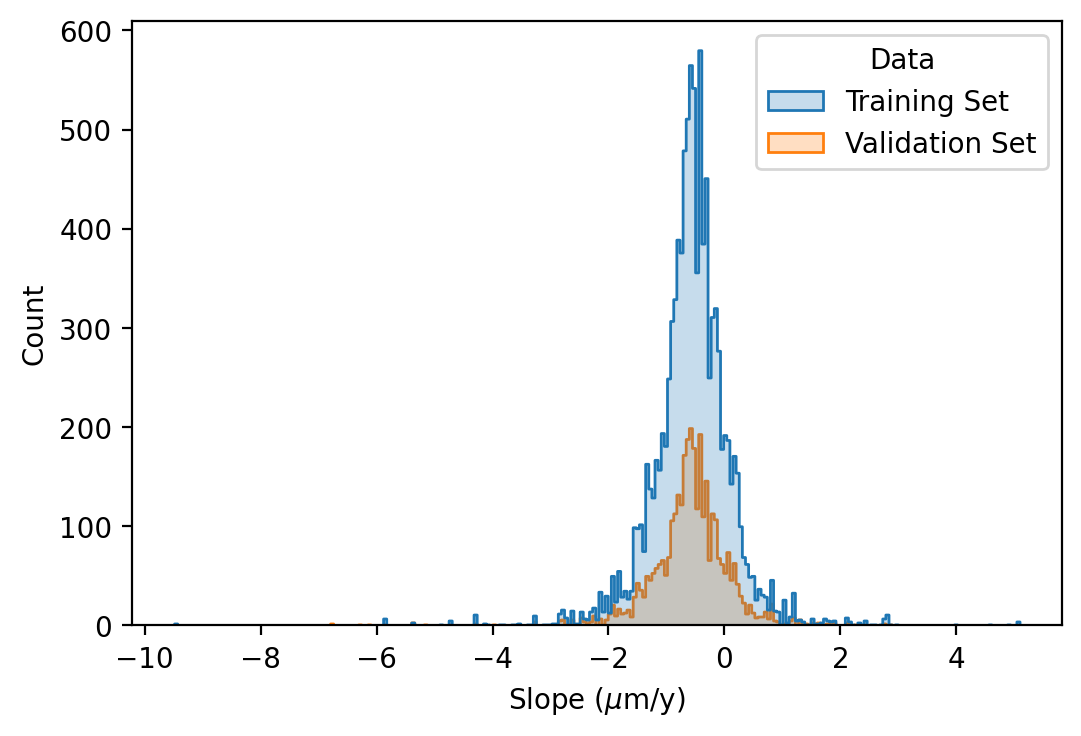

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

10449 3483


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

3


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_dict_ts3_1.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 164/164 [00:26<00:00,  6.24it/s, batch_loss=0.359, running_loss=82.7]


Train Loss: 82.7302 | Valid Loss: inf ===========> 28.5572 | Test Loss: 33.4332 | Saving model...


Epoch [2/200]: 100%|██████████| 164/164 [00:26<00:00,  6.09it/s, batch_loss=2.26, running_loss=83.4]


Train Loss: 83.3825 | Valid Loss: 29.3156


Epoch [3/200]: 100%|██████████| 164/164 [00:26<00:00,  6.12it/s, batch_loss=0.311, running_loss=81.7]


Train Loss: 81.6642 | Valid Loss: 28.5572 ===========> 28.4006 | Test Loss: 33.5636 | Saving model...


Epoch [4/200]: 100%|██████████| 164/164 [00:26<00:00,  6.11it/s, batch_loss=0.192, running_loss=80.8]


Train Loss: 80.7558 | Valid Loss: 28.4006 ===========> 28.1823 | Test Loss: 33.4357 | Saving model...


Epoch [5/200]: 100%|██████████| 164/164 [00:26<00:00,  6.10it/s, batch_loss=0.159, running_loss=79.6]


Train Loss: 79.5887 | Valid Loss: 28.1823 ===========> 27.5609 | Test Loss: 32.7700 | Saving model...


Epoch [6/200]: 100%|██████████| 164/164 [00:26<00:00,  6.10it/s, batch_loss=0.55, running_loss=78.8]


Train Loss: 78.7570 | Valid Loss: 29.2065


Epoch [7/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.392, running_loss=76.8]


Train Loss: 76.8333 | Valid Loss: 38.0251


Epoch [8/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.354, running_loss=74.5]


Train Loss: 74.5243 | Valid Loss: 28.0097


Epoch [9/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.383, running_loss=72.4]


Train Loss: 72.3642 | Valid Loss: 30.4688


Epoch [10/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.688, running_loss=69.2]


Train Loss: 69.1785 | Valid Loss: 27.9858


Epoch [11/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.192, running_loss=67.1]


Train Loss: 67.1450 | Valid Loss: 27.5609 ===========> 26.8573 | Test Loss: 31.7207 | Saving model...


Epoch [12/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.202, running_loss=62.9]


Train Loss: 62.9472 | Valid Loss: 26.8573 ===========> 26.3174 | Test Loss: 30.8701 | Saving model...


Epoch [13/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.124, running_loss=58.9]


Train Loss: 58.8845 | Valid Loss: 26.3174 ===========> 25.9721 | Test Loss: 30.6016 | Saving model...


Epoch [14/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.257, running_loss=56.4]


Train Loss: 56.4175 | Valid Loss: 35.1446


Epoch [15/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.296, running_loss=52]


Train Loss: 52.0038 | Valid Loss: 27.4996


Epoch [16/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.261, running_loss=46.1]


Train Loss: 46.1489 | Valid Loss: 25.9721 ===========> 25.8739 | Test Loss: 30.0937 | Saving model...


Epoch [17/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0608, running_loss=42.2]


Train Loss: 42.1634 | Valid Loss: 25.8739 ===========> 24.5681 | Test Loss: 27.7444 | Saving model...


Epoch [18/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0918, running_loss=36.8]


Train Loss: 36.8440 | Valid Loss: 24.5681 ===========> 24.1402 | Test Loss: 27.2868 | Saving model...


Epoch [19/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0888, running_loss=32.3]


Train Loss: 32.3312 | Valid Loss: 25.9684


Epoch [20/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.293, running_loss=28]


Train Loss: 27.9700 | Valid Loss: 26.3689


Epoch [21/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.106, running_loss=26]


Train Loss: 25.9703 | Valid Loss: 24.1402 ===========> 23.3245 | Test Loss: 26.4304 | Saving model...


Epoch [22/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.159, running_loss=20.5]


Train Loss: 20.4994 | Valid Loss: 26.5358


Epoch [23/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.154, running_loss=18.3]


Train Loss: 18.2566 | Valid Loss: 23.3813


Epoch [24/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.131, running_loss=14.4]


Train Loss: 14.3688 | Valid Loss: 31.2083


Epoch [25/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.38, running_loss=15.3]


Train Loss: 15.3373 | Valid Loss: 39.5172


Epoch [26/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0587, running_loss=15.7]


Train Loss: 15.6660 | Valid Loss: 24.0255


Epoch [27/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.068, running_loss=10.4]


Train Loss: 10.3595 | Valid Loss: 23.3245 ===========> 22.0681 | Test Loss: 25.0157 | Saving model...


Epoch [28/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0429, running_loss=8.97]


Train Loss: 8.9715 | Valid Loss: 22.2719


Epoch [29/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.107, running_loss=8.04]


Train Loss: 8.0401 | Valid Loss: 22.6904


Epoch [30/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.0625, running_loss=7.78]


Train Loss: 7.7782 | Valid Loss: 22.4838


Epoch [31/200]: 100%|██████████| 164/164 [00:25<00:00,  6.32it/s, batch_loss=0.0882, running_loss=7.35]


Train Loss: 7.3486 | Valid Loss: 22.6671


Epoch [32/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0329, running_loss=7.06]


Train Loss: 7.0636 | Valid Loss: 22.0681 ===========> 21.6142 | Test Loss: 24.8878 | Saving model...


Epoch [33/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.023, running_loss=6.74]


Train Loss: 6.7354 | Valid Loss: 21.8425


Epoch [34/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0228, running_loss=5.8]


Train Loss: 5.7981 | Valid Loss: 21.8677


Epoch [35/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.0442, running_loss=5.26]


Train Loss: 5.2559 | Valid Loss: 23.8103


Epoch [36/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0361, running_loss=5.01]


Train Loss: 5.0131 | Valid Loss: 22.6571


Epoch [37/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0229, running_loss=4.67]


Train Loss: 4.6700 | Valid Loss: 21.6142 ===========> 21.4245 | Test Loss: 23.9249 | Saving model...


Epoch [38/200]: 100%|██████████| 164/164 [00:26<00:00,  6.31it/s, batch_loss=0.0254, running_loss=4.36]


Train Loss: 4.3562 | Valid Loss: 21.4714


Epoch [39/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0327, running_loss=4.6]


Train Loss: 4.6022 | Valid Loss: 22.6086


Epoch [40/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0202, running_loss=4.1]


Train Loss: 4.1012 | Valid Loss: 21.6385


Epoch [41/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0112, running_loss=4.18]


Train Loss: 4.1797 | Valid Loss: 21.5040


Epoch [42/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0293, running_loss=3.99]


Train Loss: 3.9897 | Valid Loss: 21.6721


Epoch [43/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0398, running_loss=3.99]


Train Loss: 3.9907 | Valid Loss: 21.4245 ===========> 21.2998 | Test Loss: 23.3760 | Saving model...


Epoch [44/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0163, running_loss=3.97]


Train Loss: 3.9715 | Valid Loss: 21.6379


Epoch [45/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0124, running_loss=3.61]


Train Loss: 3.6123 | Valid Loss: 21.2998 ===========> 21.1186 | Test Loss: 23.5742 | Saving model...


Epoch [46/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.00519, running_loss=3.58]


Train Loss: 3.5785 | Valid Loss: 21.5153


Epoch [47/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.0128, running_loss=3.42]


Train Loss: 3.4183 | Valid Loss: 21.2389


Epoch [48/200]: 100%|██████████| 164/164 [00:26<00:00,  6.26it/s, batch_loss=0.0165, running_loss=3.33]


Train Loss: 3.3271 | Valid Loss: 21.1186 ===========> 20.9958 | Test Loss: 23.9219 | Saving model...


Epoch [49/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0155, running_loss=3.3]


Train Loss: 3.2953 | Valid Loss: 21.0693


Epoch [50/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.0226, running_loss=3.18]


Train Loss: 3.1838 | Valid Loss: 20.9958 ===========> 20.9556 | Test Loss: 23.4133 | Saving model...


Epoch [51/200]: 100%|██████████| 164/164 [00:26<00:00,  6.31it/s, batch_loss=0.0536, running_loss=3.05]


Train Loss: 3.0511 | Valid Loss: 20.9720


Epoch [52/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0148, running_loss=3.1]


Train Loss: 3.0982 | Valid Loss: 21.2599


Epoch [53/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0148, running_loss=2.96]


Train Loss: 2.9619 | Valid Loss: 21.0115


Epoch [54/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0173, running_loss=2.91]


Train Loss: 2.9142 | Valid Loss: 20.9661


Epoch [55/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.0154, running_loss=2.8]


Train Loss: 2.7977 | Valid Loss: 21.2618


Epoch [56/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0117, running_loss=2.73]


Train Loss: 2.7280 | Valid Loss: 20.9878


Epoch [57/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0205, running_loss=2.7]


Train Loss: 2.7003 | Valid Loss: 20.9556 ===========> 20.7247 | Test Loss: 24.8637 | Saving model...


Epoch [58/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.026, running_loss=2.72]


Train Loss: 2.7160 | Valid Loss: 21.0996


Epoch [59/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.0114, running_loss=2.52]


Train Loss: 2.5239 | Valid Loss: 20.9309


Epoch [60/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0156, running_loss=2.59]


Train Loss: 2.5928 | Valid Loss: 20.9078


Epoch [61/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0563, running_loss=2.64]


Train Loss: 2.6351 | Valid Loss: 21.6563


Epoch [62/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.027, running_loss=2.75]


Train Loss: 2.7463 | Valid Loss: 20.7784


Epoch [63/200]: 100%|██████████| 164/164 [00:26<00:00,  6.31it/s, batch_loss=0.089, running_loss=2.63]


Train Loss: 2.6299 | Valid Loss: 21.5094


Epoch [64/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0133, running_loss=2.97]


Train Loss: 2.9719 | Valid Loss: 21.2326


Epoch [65/200]: 100%|██████████| 164/164 [00:25<00:00,  6.31it/s, batch_loss=0.00824, running_loss=2.43]


Train Loss: 2.4293 | Valid Loss: 20.8888


Epoch [66/200]: 100%|██████████| 164/164 [00:25<00:00,  6.32it/s, batch_loss=0.00555, running_loss=2.45]


Train Loss: 2.4524 | Valid Loss: 20.9435


Epoch [67/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0134, running_loss=2.33]


Train Loss: 2.3329 | Valid Loss: 20.7247 ===========> 20.6496 | Test Loss: 23.4624 | Saving model...


Epoch [68/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.0198, running_loss=2.33]


Train Loss: 2.3258 | Valid Loss: 20.7460


Epoch [69/200]: 100%|██████████| 164/164 [00:26<00:00,  6.17it/s, batch_loss=0.0113, running_loss=2.21]


Train Loss: 2.2140 | Valid Loss: 20.7793


Epoch [70/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0156, running_loss=2.34]


Train Loss: 2.3382 | Valid Loss: 20.9128


Epoch [71/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.0113, running_loss=2.19]


Train Loss: 2.1940 | Valid Loss: 20.9791


Epoch [72/200]: 100%|██████████| 164/164 [00:26<00:00,  6.27it/s, batch_loss=0.00257, running_loss=2.19]


Train Loss: 2.1870 | Valid Loss: 20.7022


Epoch [73/200]: 100%|██████████| 164/164 [00:26<00:00,  6.25it/s, batch_loss=0.0164, running_loss=2.19]


Train Loss: 2.1947 | Valid Loss: 20.8675


Epoch [74/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0181, running_loss=2.1]


Train Loss: 2.0998 | Valid Loss: 20.6496 ===========> 20.4530 | Test Loss: 23.0639 | Saving model...


Epoch [75/200]: 100%|██████████| 164/164 [00:26<00:00,  6.28it/s, batch_loss=0.0075, running_loss=2.13]


Train Loss: 2.1310 | Valid Loss: 20.8394


Epoch [76/200]: 100%|██████████| 164/164 [00:26<00:00,  6.29it/s, batch_loss=0.0164, running_loss=2.12]


Train Loss: 2.1163 | Valid Loss: 20.4722


Epoch [77/200]: 100%|██████████| 164/164 [00:25<00:00,  6.31it/s, batch_loss=0.0158, running_loss=2.07]


Train Loss: 2.0710 | Valid Loss: 20.9893


Epoch [78/200]: 100%|██████████| 164/164 [00:25<00:00,  6.33it/s, batch_loss=0.015, running_loss=2.08]


Train Loss: 2.0821 | Valid Loss: 20.8086


Epoch [79/200]: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s, batch_loss=0.0112, running_loss=2.04]


Train Loss: 2.0418 | Valid Loss: 20.5105


Epoch [80/200]: 100%|██████████| 164/164 [00:25<00:00,  6.39it/s, batch_loss=0.0123, running_loss=1.96]


Train Loss: 1.9617 | Valid Loss: 20.6951


Epoch [81/200]: 100%|██████████| 164/164 [00:25<00:00,  6.45it/s, batch_loss=0.0118, running_loss=2]


Train Loss: 2.0009 | Valid Loss: 20.4590


Epoch [82/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.0147, running_loss=2.02]


Train Loss: 2.0229 | Valid Loss: 20.5104


Epoch [83/200]: 100%|██████████| 164/164 [00:25<00:00,  6.49it/s, batch_loss=0.0227, running_loss=1.94]


Train Loss: 1.9378 | Valid Loss: 20.7948


Epoch [84/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.00635, running_loss=1.88]


Train Loss: 1.8840 | Valid Loss: 20.8332


Epoch [85/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.0189, running_loss=1.85]


Train Loss: 1.8467 | Valid Loss: 20.7125


Epoch [86/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.00753, running_loss=1.85]


Train Loss: 1.8465 | Valid Loss: 20.5569


Epoch [87/200]: 100%|██████████| 164/164 [00:25<00:00,  6.49it/s, batch_loss=0.00902, running_loss=1.81]


Train Loss: 1.8128 | Valid Loss: 20.4530 ===========> 20.2838 | Test Loss: 22.8684 | Saving model...


Epoch [88/200]: 100%|██████████| 164/164 [00:25<00:00,  6.49it/s, batch_loss=0.0119, running_loss=1.77]


Train Loss: 1.7710 | Valid Loss: 20.3670


Epoch [89/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.00609, running_loss=1.79]


Train Loss: 1.7941 | Valid Loss: 20.3761


Epoch [90/200]: 100%|██████████| 164/164 [00:25<00:00,  6.52it/s, batch_loss=0.00958, running_loss=1.85]


Train Loss: 1.8492 | Valid Loss: 20.3900


Epoch [91/200]: 100%|██████████| 164/164 [00:25<00:00,  6.51it/s, batch_loss=0.00624, running_loss=1.74]


Train Loss: 1.7416 | Valid Loss: 20.7240


Epoch [92/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.0565, running_loss=1.75]


Train Loss: 1.7451 | Valid Loss: 20.3786


Epoch [93/200]: 100%|██████████| 164/164 [00:25<00:00,  6.51it/s, batch_loss=0.00989, running_loss=1.72]


Train Loss: 1.7217 | Valid Loss: 20.4608


Epoch [94/200]: 100%|██████████| 164/164 [00:25<00:00,  6.49it/s, batch_loss=0.0111, running_loss=1.78]


Train Loss: 1.7787 | Valid Loss: 20.6405


Epoch [95/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.00563, running_loss=1.67]


Train Loss: 1.6695 | Valid Loss: 20.3678


Epoch [96/200]: 100%|██████████| 164/164 [00:25<00:00,  6.49it/s, batch_loss=0.0119, running_loss=1.63]


Train Loss: 1.6336 | Valid Loss: 20.5017


Epoch [97/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.0175, running_loss=1.63]


Train Loss: 1.6293 | Valid Loss: 20.3205


Epoch [98/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.00919, running_loss=1.73]


Train Loss: 1.7265 | Valid Loss: 20.3143


Epoch [99/200]: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s, batch_loss=0.00705, running_loss=1.59]


Train Loss: 1.5943 | Valid Loss: 20.5121


Epoch [100/200]: 100%|██████████| 164/164 [00:25<00:00,  6.49it/s, batch_loss=0.0265, running_loss=1.63]


Train Loss: 1.6300 | Valid Loss: 21.0241


Epoch [101/200]: 100%|██████████| 164/164 [00:25<00:00,  6.54it/s, batch_loss=0.00548, running_loss=1.7]


Train Loss: 1.7024 | Valid Loss: 20.4384


Epoch [102/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00935, running_loss=1.66]


Train Loss: 1.6562 | Valid Loss: 20.3723


Epoch [103/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00419, running_loss=1.6]


Train Loss: 1.6038 | Valid Loss: 20.3793


Epoch [104/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00493, running_loss=1.54]


Train Loss: 1.5363 | Valid Loss: 20.4699


Epoch [105/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00944, running_loss=1.56]


Train Loss: 1.5629 | Valid Loss: 20.5720


Epoch [106/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.015, running_loss=1.57]


Train Loss: 1.5696 | Valid Loss: 20.2942


Epoch [107/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.015, running_loss=1.57]


Train Loss: 1.5669 | Valid Loss: 20.2838 ===========> 20.2293 | Test Loss: 22.7006 | Saving model...


Epoch [108/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0109, running_loss=1.53]


Train Loss: 1.5256 | Valid Loss: 20.6853


Epoch [109/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0125, running_loss=1.5]


Train Loss: 1.4977 | Valid Loss: 20.4526


Epoch [110/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00812, running_loss=1.59]


Train Loss: 1.5855 | Valid Loss: 20.6170


Epoch [111/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0117, running_loss=1.49]


Train Loss: 1.4917 | Valid Loss: 20.2829


Epoch [112/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00999, running_loss=1.49]


Train Loss: 1.4922 | Valid Loss: 20.3958


Epoch [113/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.0215, running_loss=1.51]


Train Loss: 1.5088 | Valid Loss: 20.2293 ===========> 20.2155 | Test Loss: 22.8155 | Saving model...


Epoch [114/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00455, running_loss=1.5]


Train Loss: 1.5044 | Valid Loss: 20.2772


Epoch [115/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0119, running_loss=1.48]


Train Loss: 1.4784 | Valid Loss: 20.3227


Epoch [116/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.0112, running_loss=1.47]


Train Loss: 1.4729 | Valid Loss: 20.2155 ===========> 20.1558 | Test Loss: 22.8290 | Saving model...


Epoch [117/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0149, running_loss=1.45]


Train Loss: 1.4527 | Valid Loss: 20.4149


Epoch [118/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00939, running_loss=1.46]


Train Loss: 1.4583 | Valid Loss: 20.3548


Epoch [119/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.0192, running_loss=1.39]


Train Loss: 1.3917 | Valid Loss: 20.2764


Epoch [120/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00828, running_loss=1.4]


Train Loss: 1.3970 | Valid Loss: 20.4531


Epoch [121/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00657, running_loss=1.41]


Train Loss: 1.4092 | Valid Loss: 20.3841


Epoch [122/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.011, running_loss=1.32]


Train Loss: 1.3187 | Valid Loss: 20.2481


Epoch [123/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0101, running_loss=1.26]


Train Loss: 1.2574 | Valid Loss: 20.2186


Epoch [124/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0217, running_loss=1.31]


Train Loss: 1.3109 | Valid Loss: 20.3069


Epoch [125/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0114, running_loss=1.27]


Train Loss: 1.2680 | Valid Loss: 20.2196


Epoch [126/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00937, running_loss=1.29]


Train Loss: 1.2897 | Valid Loss: 20.1829


Epoch [127/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00388, running_loss=1.24]


Train Loss: 1.2423 | Valid Loss: 20.3061


Epoch [128/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00586, running_loss=1.21]


Train Loss: 1.2121 | Valid Loss: 20.3389


Epoch [129/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.0182, running_loss=1.22]


Train Loss: 1.2195 | Valid Loss: 20.2642


Epoch [130/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00925, running_loss=1.24]


Train Loss: 1.2381 | Valid Loss: 20.2592


Epoch [131/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.011, running_loss=1.21]


Train Loss: 1.2127 | Valid Loss: 20.2499


Epoch [132/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0202, running_loss=1.24]


Train Loss: 1.2408 | Valid Loss: 20.2444


Epoch [133/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00333, running_loss=1.2]


Train Loss: 1.1979 | Valid Loss: 20.2457


Epoch [134/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00707, running_loss=1.18]


Train Loss: 1.1782 | Valid Loss: 20.1558 ===========> 20.1281 | Test Loss: 22.6288 | Saving model...


Epoch [135/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0111, running_loss=1.21]


Train Loss: 1.2068 | Valid Loss: 20.2008


Epoch [136/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.0068, running_loss=1.19]


Train Loss: 1.1946 | Valid Loss: 20.2420


Epoch [137/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0118, running_loss=1.22]


Train Loss: 1.2206 | Valid Loss: 20.1660


Epoch [138/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.0089, running_loss=1.2]


Train Loss: 1.1955 | Valid Loss: 20.1942


Epoch [139/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00873, running_loss=1.18]


Train Loss: 1.1781 | Valid Loss: 20.2180


Epoch [140/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00456, running_loss=1.19]


Train Loss: 1.1904 | Valid Loss: 20.2434


Epoch [141/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.00791, running_loss=1.18]


Train Loss: 1.1757 | Valid Loss: 20.1837


Epoch [142/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00789, running_loss=1.17]


Train Loss: 1.1653 | Valid Loss: 20.2866


Epoch [143/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00702, running_loss=1.15]


Train Loss: 1.1544 | Valid Loss: 20.2987


Epoch [144/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.019, running_loss=1.22]


Train Loss: 1.2234 | Valid Loss: 20.1740


Epoch [145/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00907, running_loss=1.14]


Train Loss: 1.1398 | Valid Loss: 20.2233


Epoch [146/200]: 100%|██████████| 164/164 [00:25<00:00,  6.54it/s, batch_loss=0.0103, running_loss=1.13]


Train Loss: 1.1346 | Valid Loss: 20.1788


Epoch [147/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00835, running_loss=1.15]


Train Loss: 1.1459 | Valid Loss: 20.3774


Epoch [148/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00957, running_loss=1.16]


Train Loss: 1.1628 | Valid Loss: 20.4872


Epoch [149/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00982, running_loss=1.12]


Train Loss: 1.1230 | Valid Loss: 20.3288


Epoch [150/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0106, running_loss=1.15]


Train Loss: 1.1516 | Valid Loss: 20.2436


Epoch [151/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00562, running_loss=1.14]


Train Loss: 1.1367 | Valid Loss: 20.1599


Epoch [152/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00913, running_loss=1.16]


Train Loss: 1.1562 | Valid Loss: 20.2610


Epoch [153/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.0124, running_loss=1.12]


Train Loss: 1.1171 | Valid Loss: 20.1834


Epoch [154/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0114, running_loss=1.14]


Train Loss: 1.1373 | Valid Loss: 20.1990


Epoch [155/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.00597, running_loss=1.13]


Train Loss: 1.1347 | Valid Loss: 20.2463


Epoch [156/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00285, running_loss=1.11]


Train Loss: 1.1118 | Valid Loss: 20.2044


Epoch [157/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.014, running_loss=1.13]


Train Loss: 1.1296 | Valid Loss: 20.2379


Epoch [158/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00735, running_loss=1.1]


Train Loss: 1.1032 | Valid Loss: 20.2085


Epoch [159/200]: 100%|██████████| 164/164 [00:25<00:00,  6.54it/s, batch_loss=0.0106, running_loss=1.16]


Train Loss: 1.1641 | Valid Loss: 20.2734


Epoch [160/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00431, running_loss=1.17]


Train Loss: 1.1670 | Valid Loss: 20.1420


Epoch [161/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00758, running_loss=1.1]


Train Loss: 1.1024 | Valid Loss: 21.0442


Epoch [162/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00866, running_loss=1.09]


Train Loss: 1.0944 | Valid Loss: 20.6537


Epoch [163/200]: 100%|██████████| 164/164 [00:24<00:00,  6.60it/s, batch_loss=0.00694, running_loss=1.11]


Train Loss: 1.1135 | Valid Loss: 20.1654


Epoch [164/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.00437, running_loss=1.12]


Train Loss: 1.1234 | Valid Loss: 20.2233


Epoch [165/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00455, running_loss=1.1]


Train Loss: 1.1027 | Valid Loss: 20.2389


Epoch [166/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00548, running_loss=1.1]


Train Loss: 1.0994 | Valid Loss: 20.3367


Epoch [167/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00607, running_loss=1.09]


Train Loss: 1.0904 | Valid Loss: 20.1990


Epoch [168/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00623, running_loss=1.1]


Train Loss: 1.1000 | Valid Loss: 20.2183


Epoch [169/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.00358, running_loss=1.08]


Train Loss: 1.0792 | Valid Loss: 20.2401


Epoch [170/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.00458, running_loss=1.1]


Train Loss: 1.1007 | Valid Loss: 20.2111


Epoch [171/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00989, running_loss=1.1]


Train Loss: 1.1022 | Valid Loss: 20.2351


Epoch [172/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00929, running_loss=1.13]


Train Loss: 1.1272 | Valid Loss: 20.2408


Epoch [173/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0196, running_loss=1.08]


Train Loss: 1.0814 | Valid Loss: 20.2539


Epoch [174/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00805, running_loss=1.07]


Train Loss: 1.0725 | Valid Loss: 20.2341


Epoch [175/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00668, running_loss=1.13]


Train Loss: 1.1310 | Valid Loss: 20.1903


Epoch [176/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00778, running_loss=1.09]


Train Loss: 1.0946 | Valid Loss: 20.4370


Epoch [177/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00438, running_loss=1.11]


Train Loss: 1.1084 | Valid Loss: 20.2406


Epoch [178/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.00916, running_loss=1.08]


Train Loss: 1.0800 | Valid Loss: 20.2220


Epoch [179/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.0112, running_loss=1.07]


Train Loss: 1.0746 | Valid Loss: 20.2275


Epoch [180/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00929, running_loss=1.07]


Train Loss: 1.0655 | Valid Loss: 20.3054


Epoch [181/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00949, running_loss=1.11]


Train Loss: 1.1062 | Valid Loss: 20.1912


Epoch [182/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.0127, running_loss=1.13]


Train Loss: 1.1279 | Valid Loss: 20.4534


Epoch [183/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.012, running_loss=1.06]


Train Loss: 1.0611 | Valid Loss: 21.0061


Epoch [184/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00812, running_loss=1.11]


Train Loss: 1.1080 | Valid Loss: 20.2534


Epoch [185/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00721, running_loss=1.09]


Train Loss: 1.0927 | Valid Loss: 20.3143


Epoch [186/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.011, running_loss=1.09]


Train Loss: 1.0905 | Valid Loss: 20.1923


Epoch [187/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.0127, running_loss=1.11]


Train Loss: 1.1134 | Valid Loss: 20.3997


Epoch [188/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00256, running_loss=1.07]


Train Loss: 1.0742 | Valid Loss: 20.1664


Epoch [189/200]: 100%|██████████| 164/164 [00:24<00:00,  6.59it/s, batch_loss=0.00692, running_loss=1.08]


Train Loss: 1.0793 | Valid Loss: 20.3091


Epoch [190/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00744, running_loss=1.08]


Train Loss: 1.0822 | Valid Loss: 20.1965


Epoch [191/200]: 100%|██████████| 164/164 [00:24<00:00,  6.60it/s, batch_loss=0.00866, running_loss=1.05]


Train Loss: 1.0535 | Valid Loss: 20.2406


Epoch [192/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00445, running_loss=1.08]


Train Loss: 1.0830 | Valid Loss: 20.2043


Epoch [193/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.00951, running_loss=1.08]


Train Loss: 1.0831 | Valid Loss: 20.3841


Epoch [194/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00694, running_loss=1.09]


Train Loss: 1.0855 | Valid Loss: 20.1655


Epoch [195/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.0121, running_loss=1.08]


Train Loss: 1.0823 | Valid Loss: 20.2174


Epoch [196/200]: 100%|██████████| 164/164 [00:25<00:00,  6.55it/s, batch_loss=0.00628, running_loss=1.07]


Train Loss: 1.0658 | Valid Loss: 20.1992


Epoch [197/200]: 100%|██████████| 164/164 [00:24<00:00,  6.58it/s, batch_loss=0.00718, running_loss=1.08]


Train Loss: 1.0827 | Valid Loss: 20.2542


Epoch [198/200]: 100%|██████████| 164/164 [00:24<00:00,  6.57it/s, batch_loss=0.00526, running_loss=1.05]


Train Loss: 1.0547 | Valid Loss: 21.0733


Epoch [199/200]: 100%|██████████| 164/164 [00:24<00:00,  6.56it/s, batch_loss=0.0106, running_loss=1.07]


Train Loss: 1.0703 | Valid Loss: 21.0937


Epoch [200/200]: 100%|██████████| 164/164 [00:25<00:00,  6.56it/s, batch_loss=0.00923, running_loss=1.11]


Train Loss: 1.1055 | Valid Loss: 20.2217


Train Loss: 1.1782 | Valid Loss: 20.1281 | Test Loss on Best Model: 22.6288


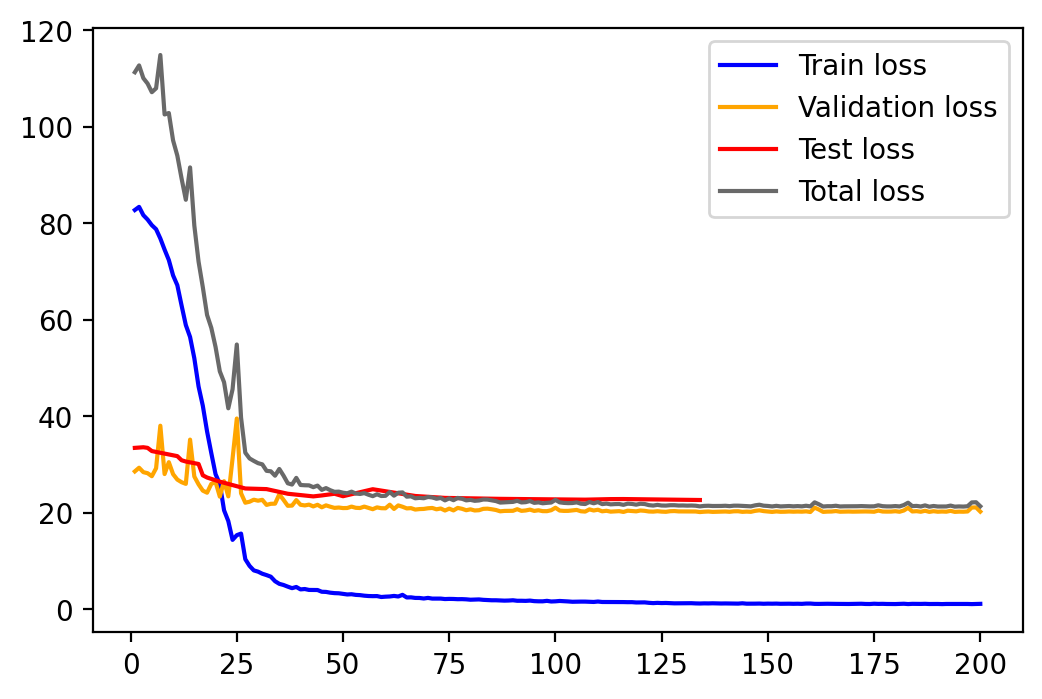

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('state_dict_ts3_1.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


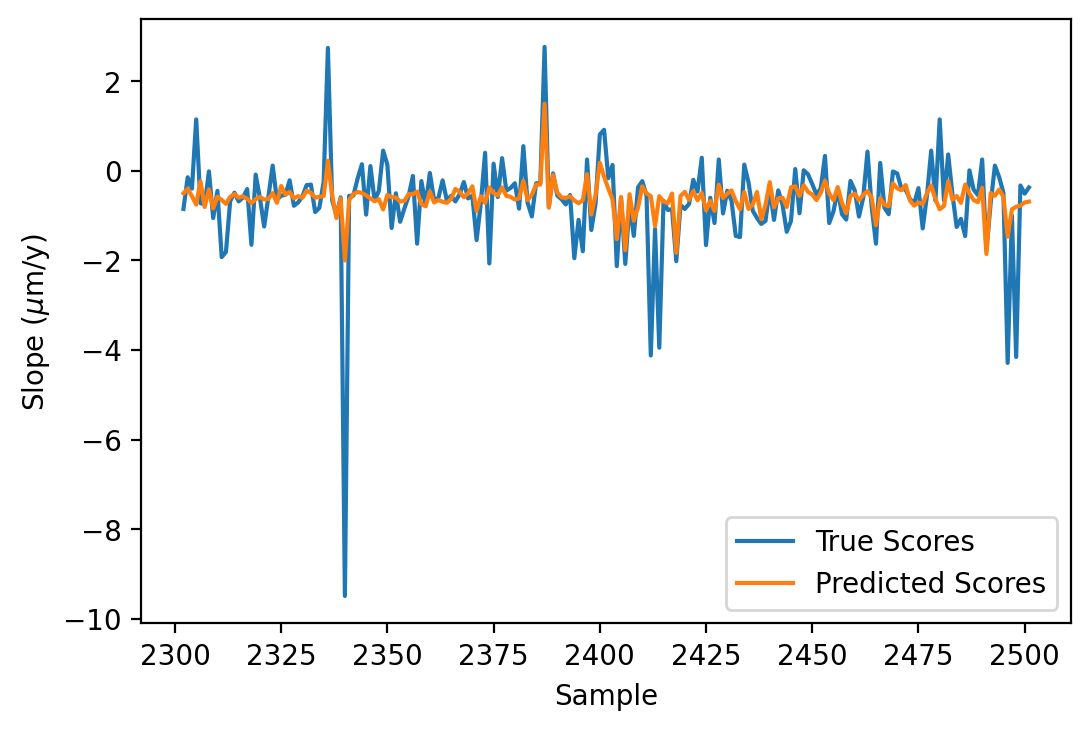

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

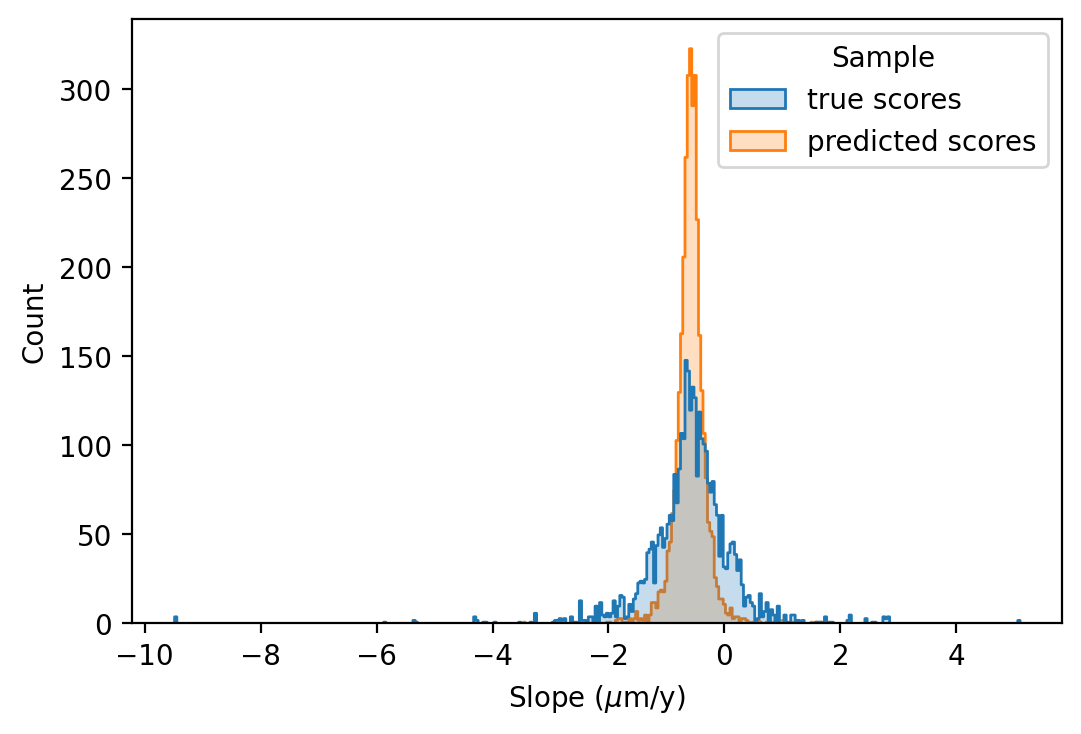

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.20005740528128588, pvalue=2.19437093388756e-61)


In [13]:
df.to_csv('predscores.csv')

In [14]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [15]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('predscores.csv')

In [17]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [18]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [19]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [20]:
coefficient_of_dermination

0.31945569138016583

In [21]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [22]:
rsquared(true, pred)

0.39869405925571694

In [23]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6224593509447944, pvalue=0.0)

In [24]:
scipy.stats.pearsonr(true, pred)

(0.6314222511566386, 0.0)